In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss

import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import warnings 
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import os

import circlify
import plotly.express as px

import joblib

In [2]:
selected_features = [
    "Married", "Never-married", "Bachelors", "Masters", "HS-grad", 
    "Capital-gain", "Exec-managerial", "Other-service", 
    "Own-child", "Unmarried", "Male"
]

bankA_data = pd.read_csv("BankA_Clean.csv")
bankB_data = pd.read_csv("BankB_Clean.csv")
bankC_data = pd.read_csv("BankC_Clean.csv")

In [3]:
combined_data = pd.concat([bankA_data, bankB_data, bankC_data], axis=0)

combined_data["income"] = combined_data["income"].astype(int)

print("Shape of combined data:", combined_data.shape)

Shape of combined data: (799999, 97)


In [4]:
column_mapping = {
    "marital-status_Married-civ-spouse": "Married",
    "marital-status_Never-married": "Never-married",
    "education_Bachelors": "Bachelors",
    "education_Masters": "Masters",
    "education_HS-grad": "HS-grad",
    "capital-gain": "Capital-gain",
    "occupation_Exec-managerial": "Exec-managerial",
    "occupation_Other-service": "Other-service",
    "relationship_Own-child": "Own-child",
    "relationship_Unmarried": "Unmarried",
    "sex_Male": "Male",
}


In [5]:
combined_data.rename(columns=column_mapping, inplace=True)

selected_columns = list(column_mapping.values()) + ["income"]
combined_data = combined_data[selected_columns]


In [8]:
X = combined_data[selected_features]
y = combined_data["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[0]	train-auc:0.83740	val-auc:0.84014
[50]	train-auc:0.88269	val-auc:0.88488
[100]	train-auc:0.88399	val-auc:0.88602
[150]	train-auc:0.88436	val-auc:0.88621
[199]	train-auc:0.88455	val-auc:0.88625
Test AUC: 0.886247520659685


Test AUC,▁
Test AUC,0.88625


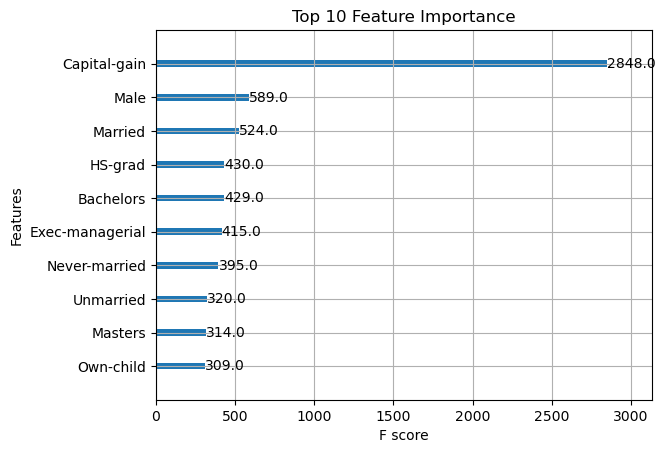

In [12]:
wandb.init(
    project="global-model",
    name="baseline-run",
    config={
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 6,
        "learning_rate": 0.1466,
        "subsample": 0.9383,
        "colsample_bytree": 0.8631,
        "min_child_weight": 6,
        "n_estimators": 200,
        "reg_alpha": 0.9566,
        "reg_lambda": 1.866,
        "early_stopping_rounds": 500
    },
    reinit=True
)

config = wandb.config

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
dval = xgb.DMatrix(X_test, label=y_test, feature_names=list(X_test.columns))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X_test.columns))


params = {
    "objective": config.objective,
    "eval_metric": config.eval_metric,
    "max_depth": config.max_depth,
    "learning_rate": config.learning_rate,
    "subsample": config.subsample,
    "colsample_bytree": config.colsample_bytree,
    "min_child_weight": config.min_child_weight,
    "reg_alpha": config.reg_alpha,
    "reg_lambda": config.reg_lambda,
}


num_boost_round = config.n_estimators
early_stopping_rounds = config.early_stopping_rounds

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=50,
)

y_test_preds = bst.predict(dtest)
auc_test = roc_auc_score(y_test, y_test_preds)

wandb.log({"Test AUC": auc_test})

xgb.plot_importance(bst, importance_type="weight", max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.savefig("top10_feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("top10_feature_importance.png")})

bst.save_model("global_model.json")
wandb.save("global_model.json")


wandb.finish()